In [9]:
import numpy as np
import matplotlib.pyplot as plt
from phystem.systems.ring.quantities import grids
from phystem.systems.ring import utils


In [4]:
from pathlib import Path
import yaml

class State:
    def __init__(self, pos, angle, ids) -> None:
        self.pos = pos
        self.angle = angle
        self.ids = ids

def load(root_dir):
    root = Path(root_dir)/"autosave"

    pos = np.load(root/"pos.npy")
    angle = np.load(root/"angle.npy")
    ids = np.load(root/"ids.npy")

    with open(root/"config.yaml") as f:
        configs = yaml.unsafe_load(f)
    
    return State(pos, angle, ids), configs

In [70]:
root_dir = "data/low_adh_align"
save_dir = "/home/marcos/Desktop"
to_save = False

col_shape = 1

state, cfg = load(root_dir)
flux = cfg["other_cfgs"]["stokes"].flux_force
space = cfg["space_cfg"]

r = utils.get_ring_radius(
    p_diameter=cfg["dynamic_cfg"].diameter,
    num_particles=cfg["creator_cfg"].num_p)

num_cols = int(space.length/(col_shape*2*r))
grid = grids.RegularGrid(space.length, space.height, num_cols, 1)

# num_cols = int(space.length/(2*2*r))
# num_rows = int(space.height/(2*2*r))
# grid = grids.RegularGrid(space.length, space.height, num_cols, num_rows)


cm = utils.get_cm(state.pos)
coords = grid.coords(cm)
count = grid.count(coords)

(1, 200)
50.0


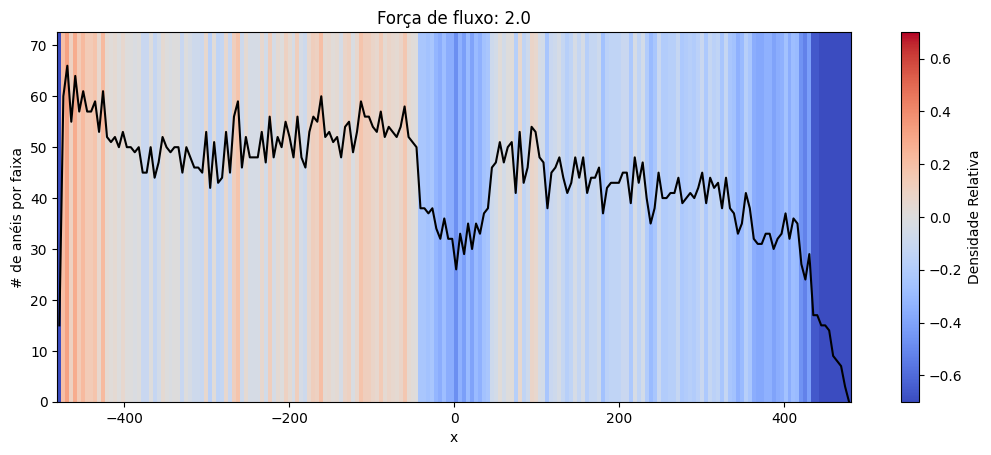

In [71]:
fig, ax = plt.subplots()

w, h = fig.get_size_inches()
fig.set_size_inches(w*2, h)

ax.plot(grid.dim_cell_center[0], count[0], c="black")

density_eq = space.height/(2*r)
cmap_amp = 0.7

print(count.shape)

density_graph = ax.pcolormesh(*grid.edges, count/density_eq - 1, shading='flat', cmap="coolwarm", vmin=-cmap_amp, vmax=cmap_amp)
fig.colorbar(density_graph, label="Densidade Relativa")

ax.set_title(f"Força de fluxo: {flux}")
ax.set_ylim(0, count.max()*1.1)
ax.set_xlabel("x")
ax.set_ylabel("# de anéis por faixa")

print(density_eq)

if to_save:
    plt.savefig(Path(save_dir)/f"density_f{flux}.png")
else:
    plt.show()